In [1]:
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
import time
import numpy as np

## Sliding Window

In [2]:
def slidingWindow(image_size, init_size=(64,64), x_overlap=0.5, y_step=0.05,
        x_range=(0, 1), y_range=(0, 1), scale=1.5):

    """
    Run a sliding window across an input image and return a list of the
    coordinates of each window.
    Window travels the width of the image (in the +x direction) at a range of
    heights (toward the bottom of the image in the +y direction). At each
    successive y, the size of the window is increased by a factor equal to
    @param scale. The horizontal search area is limited by @param x_range
    and the vertical search area by @param y_range.
    @param image_size (int, int): Size of the image (width, height) in pixels.
    @param init_size (int, int): Initial size of of the window (width, height)
        in pixels at the initial y, given by @param y_range[0].
    @param x_overlap (float): Overlap between adjacent windows at a given y
        as a float in the interval [0, 1), where 0 represents no overlap
        and 1 represents 100% overlap.
    @param y_step (float): Distance between successive heights y as a
        fraction between (0, 1) of the total height of the image.
    @param x_range (float, float): (min, max) bounds of the horizontal search
        area as a fraction of the total width of the image.
    @param y_range (float, float) (min, max) bounds of the vertical search
        area as a fraction of the total height of the image.
    @param scale (float): Factor by which to scale up window size at each y.
    @return windows: List of tuples, where each tuple represents the
        coordinates of a window in the following order: (upper left corner
        x coord, upper left corner y coord, lower right corner x coord,
        lower right corner y coord).
    """

    windows = []
    h, w = image_size[1], image_size[0]
    for y in range(int(y_range[0] * h), int(y_range[1] * h), int(y_step * h)):
        win_width = int(init_size[0] + (scale * (y - (y_range[0] * h))))
        win_height = int(init_size[1] + (scale * (y - (y_range[0] * h))))
        if y + win_height > int(y_range[1] * h) or win_width > w:
            break
        x_step = int((1 - x_overlap) * win_width)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + win_width, y + win_height))

    return windows

## Load Test Images

../dataset/0003/000038.png


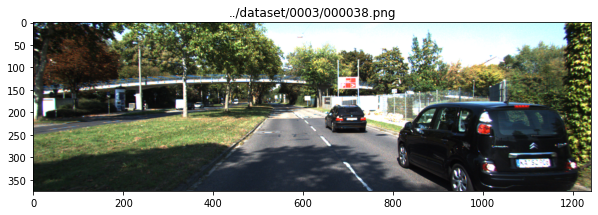

In [9]:
import cv2
from random import randint
import matplotlib.pyplot as plt

# seq_id = randint(0,3)
# frame_id = randint(0,143)
seq_id = 3
frame_id = 38

img_path = f'../dataset/{seq_id:04d}/{frame_id:06d}.png'
print(img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plot image
plt.figure(figsize=(10,10))
plt.title(img_path)
plt.imshow(img)

plt.show()

## Load Model

In [10]:
import pickle
from sklearn import svm

model_path = "../classification/models/svm.sav"

clf = pickle.load(open(model_path, 'rb'))

print(clf)

SVC(C=10)
